In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math

In [3]:
api = wandb.Api(timeout=19)

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    
    for key in keys:
        if config1[key] != config2[key]:
            return False

    # if config1['brightness_factor'] > np.abs(config1['brightness_factor_eval']):
    #     return False
    
    return True

In [6]:
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                            "config.homeostasis": 0, "config.normtype": 0,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                            "config.homeostasis": 0, "config.normtype": 1,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_Homeostatic_Sweep', filters={"config.dataset": "fashionmnist", 
                                                                "config.homeostasis": 1, "config.normtype": 0,
                                                                "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 0 }, order="-summary_metrics.test_acc")

0


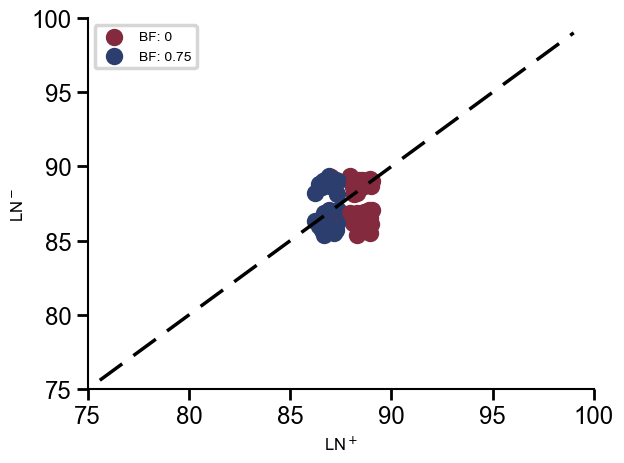

In [73]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')

#lambs = [1, 10, 100, 1000]
#lambs = [150, 300, 400, 500]
lambs = [300]

values = np.linspace(0, 1, len(lambs))

top_n = len(runs_dict["runs_vanilla_dann"])
# print(f"Here: {top_n}")

activate_color_1 = True
activate_color_2 = True
data_1 = []
data_2 = []
counter = 0


for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            #832a3e
            #2b3e6d
            if rn.config['lr'] > 0.1 or rn.config['lr'] < 0.01:
                continue

            if rn.config["brightness_factor"] == 0:
                plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="#832a3e", label="BF: 0" if activate_color_1 else None)
                data_1.append([rn.summary['test_acc'], vanilla_dann_acc])
                activate_color_1 = False
            else:
                plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="#2b3e6d", label="BF: 0.75" if activate_color_2 else None)
                data_2.append([rn.summary['test_acc'], vanilla_dann_acc])
                activate_color_2 = False


print(counter)
ax.set_xlabel("LN$^+$")
ax.set_ylabel("LN$^-$")
ax.legend(fontsize=10)
#ax.set_title(f'Brightness Factor {bright_factor}')
ax.set_xlim(75,100)
ax.set_ylim(75,100)
list_line = range(100)
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')

0


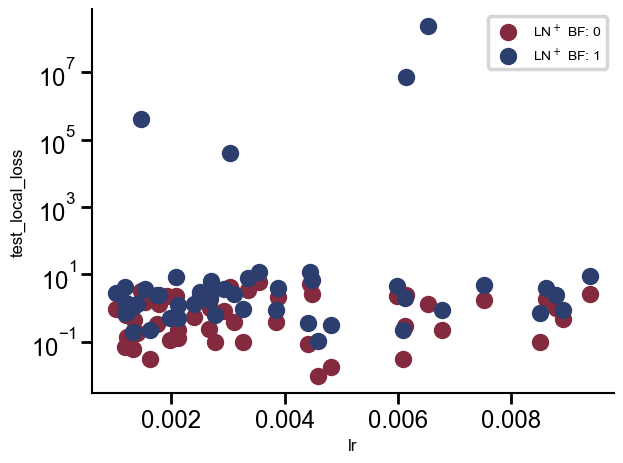

In [45]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')

#lambs = [1, 10, 100, 1000]
#lambs = [150, 300, 400, 500]
lambs = [300]

values = np.linspace(0, 1, len(lambs))

top_n = len(runs_dict["runs_vanilla_dann"])
# print(f"Here: {top_n}")

activate_color_1 = True
activate_color_2 = True
counter = 0


for rn in runs_dict["runs_homeostasis"]:
    if rn.summary['test_local_loss'] == "NaN":
        continue
    if rn.config["brightness_factor"] == 0: #rn.summary['test_acc']
        plt.scatter(rn.config['lr'], rn.summary['test_local_loss'], color="#832a3e", label="LN$^+$ BF: 0" if activate_color_1 else None)
        activate_color_1 = False
    elif rn.config["brightness_factor"] == 1:
        plt.scatter(rn.config['lr'], rn.summary['test_local_loss'], color="#2b3e6d", label="LN$^+$ BF: 1" if activate_color_2 else None)
        activate_color_2 = False


print(counter)
ax.set_xlabel("lr")
ax.set_ylabel("test_local_loss")
# ax.set_xlim(0,10)
#ax.set_ylim(0,10)
ax.set_yscale('log')
ax.legend(fontsize=10)
#ax.set_title(f'Brightness Factor {bright_factor}')
#ax.set_xlim(80,100)
#list_line = range(100)
#ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')

0


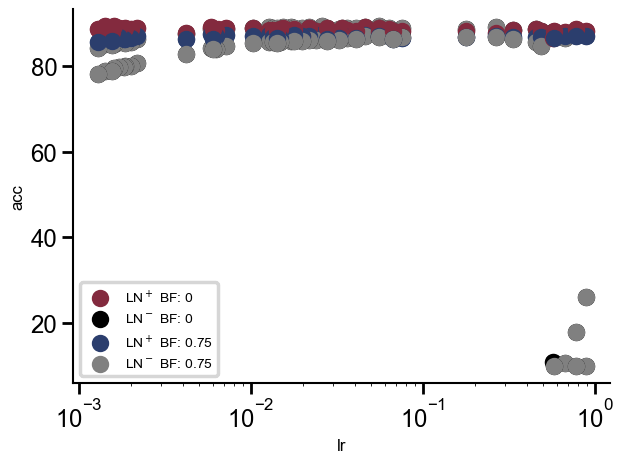

In [62]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')

#lambs = [1, 10, 100, 1000]
#lambs = [150, 300, 400, 500]
lambs = [300]

values = np.linspace(0, 1, len(lambs))

top_n = len(runs_dict["runs_vanilla_dann"])
# print(f"Here: {top_n}")

activate_color_1 = True
activate_color_2 = True
counter = 0


for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            #832a3e
            #2b3e6d
            if rn.config["brightness_factor"] == 0:
                plt.scatter(rn.config['lr'], rn.summary['test_acc'], color="#832a3e", label="LN$^+$ BF: 0" if activate_color_1 else None)
                plt.scatter(rn.config['lr'], vanilla_dann_acc, color="black", label="LN$^-$ BF: 0" if activate_color_1 else None)
                activate_color_1 = False
            else:
                plt.scatter(rn.config['lr'], rn.summary['test_acc'], color="#2b3e6d", label="LN$^+$ BF: 0.75" if activate_color_2 else None)
                plt.scatter(rn.config['lr'], vanilla_dann_acc, color="gray", label="LN$^-$ BF: 0.75" if activate_color_2 else None)
                activate_color_2 = False


print(counter)
ax.set_xlabel("lr")
ax.set_ylabel("acc")
ax.set_xscale('log')
ax.legend(fontsize=10)
#ax.set_title(f'Brightness Factor {bright_factor}')
#ax.set_xlim(80,100)
#list_line = range(100)
#ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')

0


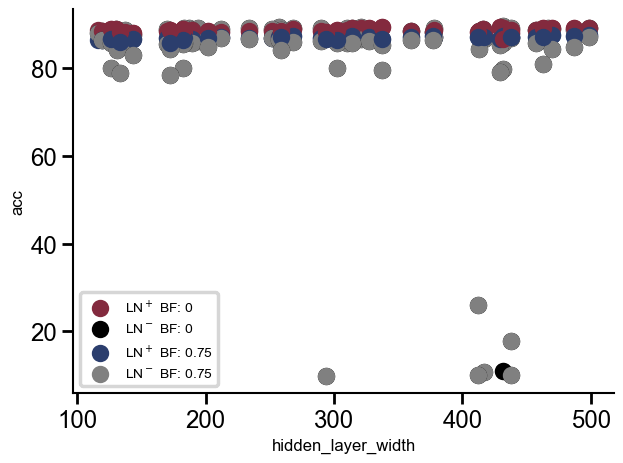

In [63]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')

#lambs = [1, 10, 100, 1000]
#lambs = [150, 300, 400, 500]
lambs = [300]

values = np.linspace(0, 1, len(lambs))

top_n = len(runs_dict["runs_vanilla_dann"])
# print(f"Here: {top_n}")

activate_color_1 = True
activate_color_2 = True
counter = 0


for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            #832a3e
            #2b3e6d
            if rn.config["brightness_factor"] == 0:
                plt.scatter(rn.config['hidden_layer_width'], rn.summary['test_acc'], color="#832a3e", label="LN$^+$ BF: 0" if activate_color_1 else None)
                plt.scatter(rn.config['hidden_layer_width'], vanilla_dann_acc, color="black", label="LN$^-$ BF: 0" if activate_color_1 else None)
                activate_color_1 = False
            else:
                plt.scatter(rn.config['hidden_layer_width'], rn.summary['test_acc'], color="#2b3e6d", label="LN$^+$ BF: 0.75" if activate_color_2 else None)
                plt.scatter(rn.config['hidden_layer_width'], vanilla_dann_acc, color="gray", label="LN$^-$ BF: 0.75" if activate_color_2 else None)
                activate_color_2 = False


print(counter)
ax.set_xlabel("hidden_layer_width")
ax.set_ylabel("acc")
#ax.set_xscale('log')
ax.legend(fontsize=10)
#ax.set_title(f'Brightness Factor {bright_factor}')
#ax.set_xlim(80,100)
#list_line = range(100)
#ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')

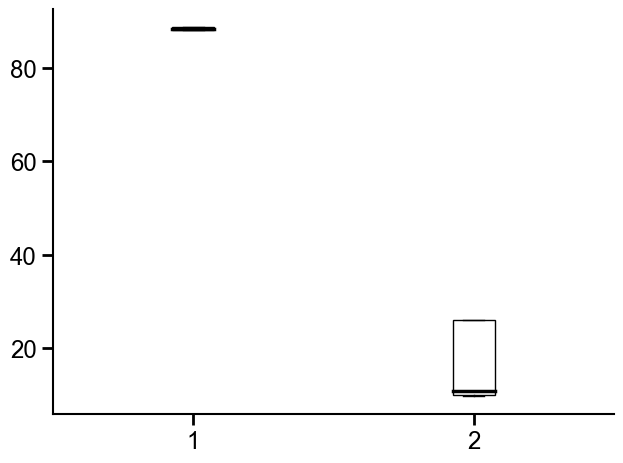

In [56]:
fig, ax = plt.subplots()
bp = ax.boxplot(np.array(data_1), patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                        showfliers=False)
#ax.set_yscale('log')

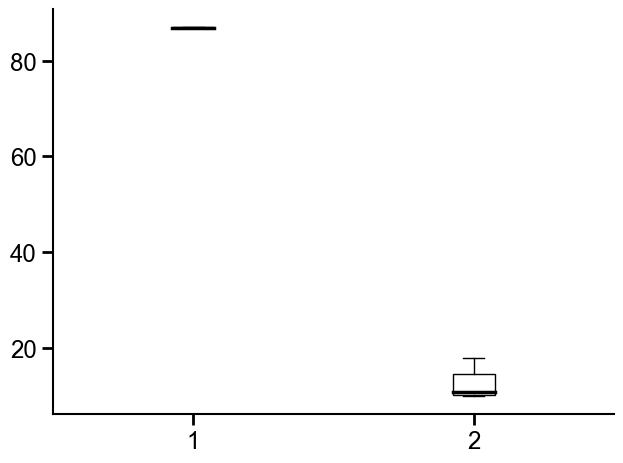

In [57]:
fig, ax = plt.subplots()
bp = ax.boxplot(np.array(data_2), patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                        showfliers=False)
#ax.set_yscale('log')